In [750]:
import pandas as pd 
import numpy as np
import scipy.stats
import pylab 
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose 
import statsmodels.tsa.stattools as sts 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from pmdarima.arima import auto_arima
import seaborn as sns

sns.set_style("darkgrid")
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

### Import Digester 15 data

In [751]:
data15 = pd.read_csv("~/Documents/Data/NNRB/Finaldata/NN_Dataset.csv")
data15.head()

,Time,Delta,Damkohler,Alpha,Sigma,CUM_Steam
0,0,0.292234,1.682447,1.702603,0.010174,25.2
1,10,0.351944,1.628414,1.694305,0.011146,26.9
2,20,0.345074,1.634916,1.695156,0.011095,27.9
3,30,0.350893,1.627947,1.694981,0.010691,28.6
4,40,0.312540,1.664536,1.699610,0.010515,25.3


<Axes: >

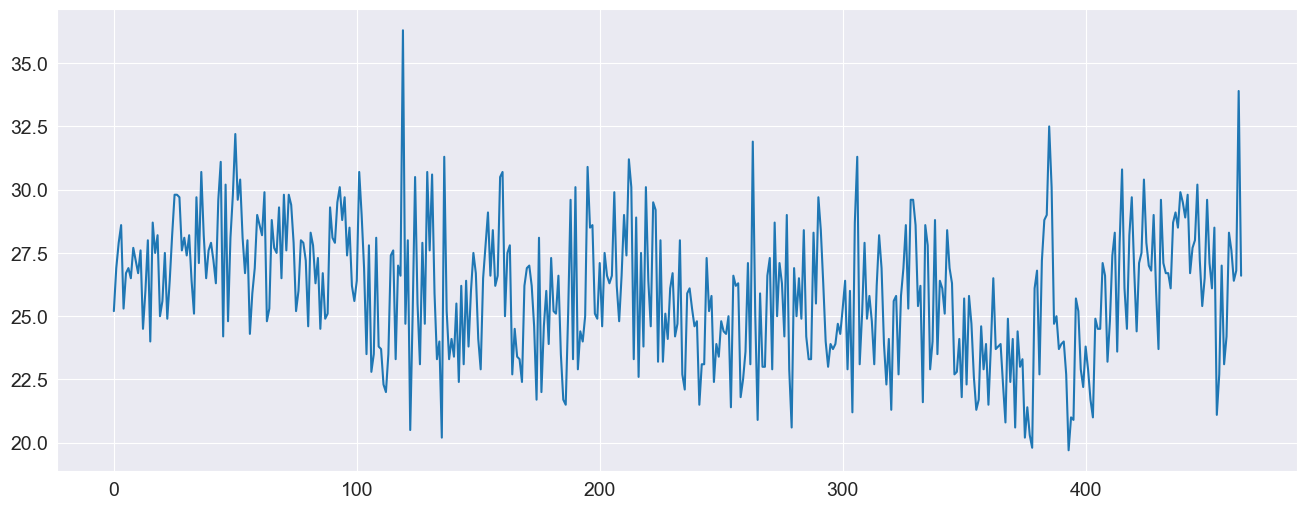

In [752]:
data15.CUM_Steam.plot()

## QQ Plot

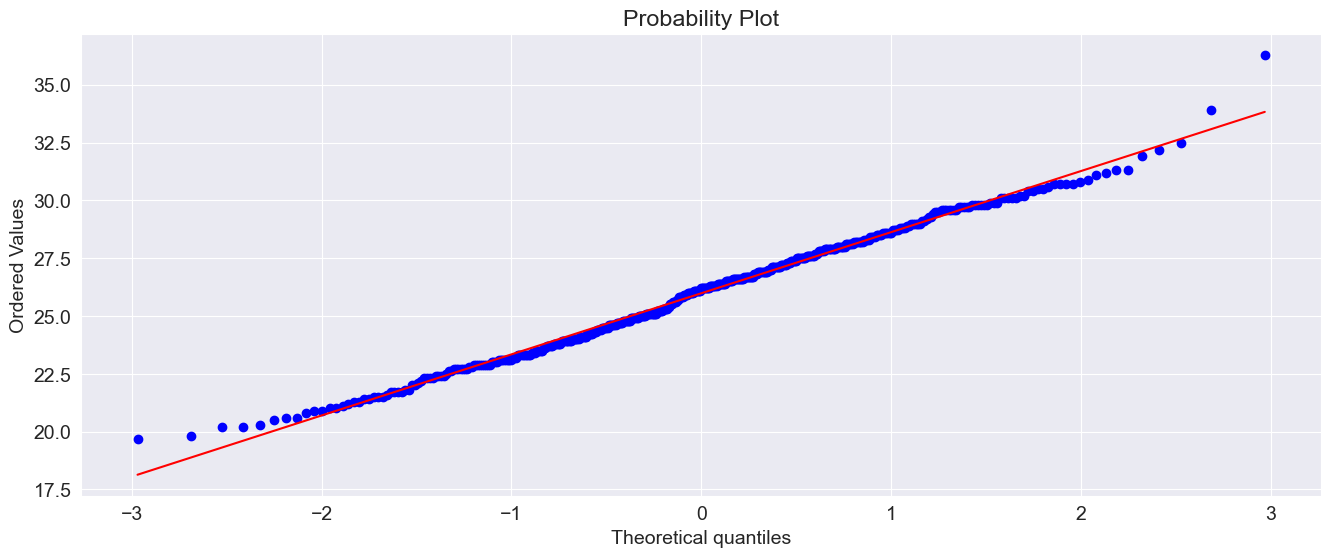

In [753]:
scipy.stats.probplot(data15.CUM_Steam, plot=pylab)
pylab.show()

In [754]:
data15.Time.describe()

count     465.000000
mean     2320.000000
std      1343.781976
min         0.000000
25%      1160.000000
50%      2320.000000
75%      3480.000000
max      4640.000000
Name: Time, dtype: float64

In [755]:
# Create a range of integers representing the time axis from 0 to 500
time_axis = range(0, len(data15))  # Assuming inclusive range from 0 to 500

# Multiply each integer by 60 to convert it to minutes
minutes = [t * 60 for t in time_axis]

# Convert the minutes to datetime format with 1-minute frequency
time_index = pd.date_range(start='2023-01-01', periods=len(minutes), freq='T')

# Assign the datetime index to the DataFrame
data15.index = time_index

# Drop the existing 'time' column
data15.drop(columns=['Time'], inplace=True)

# Rename the index to 'time'
data15.index.name = 'Time'

# Drop the existing 'Time' column if needed
data15_comp = data15.copy()

In [756]:
data15.head()

,Delta,Damkohler,Alpha,Sigma,CUM_Steam
Time,,,,,
2023-01-01 00:00:00,0.292234,1.682447,1.702603,0.010174,25.2
2023-01-01 00:01:00,0.351944,1.628414,1.694305,0.011146,26.9
2023-01-01 00:02:00,0.345074,1.634916,1.695156,0.011095,27.9
2023-01-01 00:03:00,0.350893,1.627947,1.694981,0.010691,28.6
2023-01-01 00:04:00,0.312540,1.664536,1.699610,0.010515,25.3


In [757]:
train_size = int(len(data15_comp)*0.8)
val_size = int(len(data15_comp)*0.1)

data15_train = data15_comp[:train_size]
data15_val = data15_comp[train_size:train_size+val_size]
data15_test = data15_comp[train_size+val_size:]

In [758]:
data15_test.head()

,Delta,Damkohler,Alpha,Sigma,CUM_Steam
Time,,,,,
2023-01-01 06:58:00,0.049335,1.918103,1.730646,0.011634,28.2
2023-01-01 06:59:00,0.323138,1.653200,1.698792,0.010352,29.7
2023-01-01 07:00:00,0.323667,1.646991,1.700908,0.009966,26.8
2023-01-01 07:01:00,0.344167,1.622961,1.700172,0.009983,24.4
2023-01-01 07:02:00,0.374017,1.605659,1.692276,0.010769,27.1


### Stationarity

In [759]:
sts.adfuller(data15_comp.CUM_Steam)

(-4.759509380404178,
 6.49627020900863e-05,
 6,
 458,
 {'1%': -3.4447087976702284,
  '5%': -2.867871300049488,
  '10%': -2.5701423432047443},
 2070.6125251471035)

### ACF

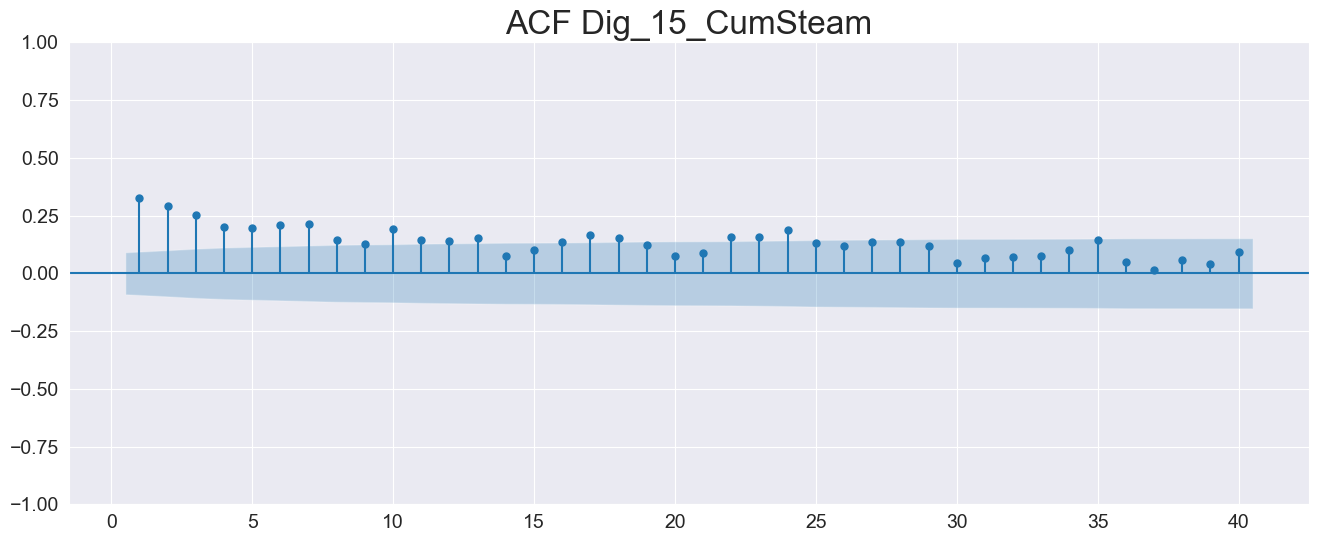

In [760]:
sgt.plot_acf(data15.CUM_Steam, lags = 40, zero = False)
plt.title("ACF Dig_15_CumSteam", size = 24)
plt.show()

### PACF

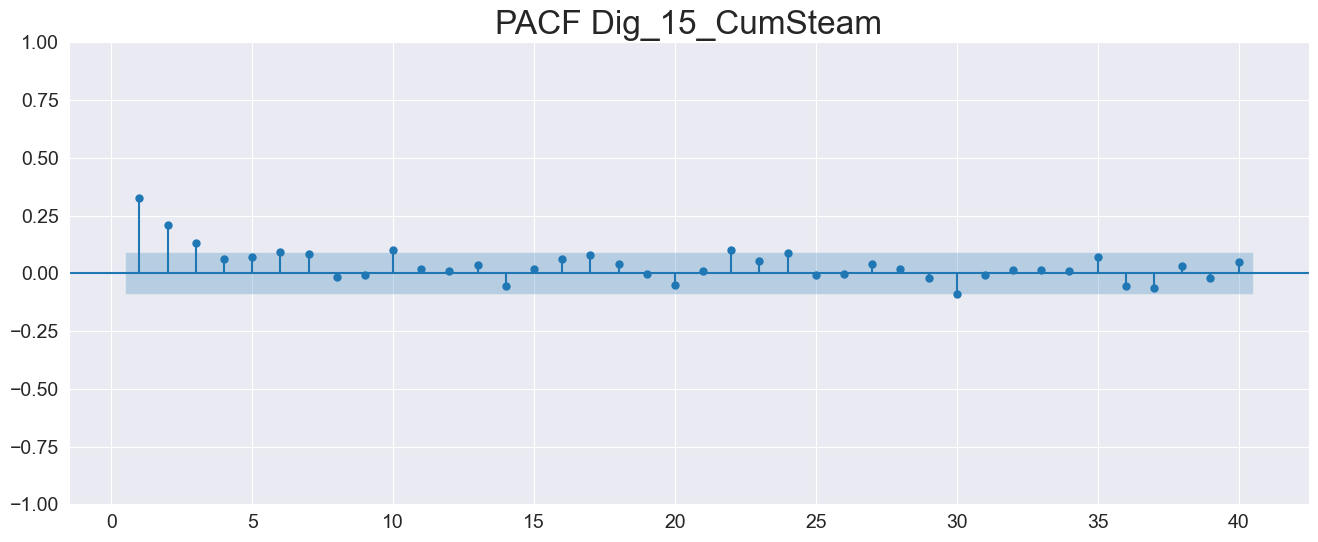

In [761]:
sgt.plot_pacf(data15.CUM_Steam, lags = 40, zero = False, method = ('ols'))
plt.title("PACF Dig_15_CumSteam", size = 24)
plt.show()

In [762]:
#LLR Test
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)

    return p

### AR Models

In [763]:
#AR1
model_ar1 = ARIMA(data15_train.CUM_Steam, order=(1, 0, 0))
results_ar1 = model_ar1.fit()
print(results_ar1.summary())

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  372
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -865.113
Date:                Thu, 22 Feb 2024   AIC                           1736.227
Time:                        15:07:11   BIC                           1747.983
Sample:                    01-01-2023   HQIC                          1740.896
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.9756      0.172    151.202      0.000      25.639      26.312
ar.L1          0.2427      0.049      4.922      0.000       0.146       0.339
sigma2         6.1294      0.459     13.342      0.0

In [764]:
#AR2
model_ar2 = ARIMA(data15_train.CUM_Steam, order=(2, 0, 0))
results_ar2 = model_ar2.fit()
print(results_ar2.summary())
print("LLR test: " + str(LLR_test(model_ar1, model_ar2)))

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  372
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -855.966
Date:                Thu, 22 Feb 2024   AIC                           1719.932
Time:                        15:07:11   BIC                           1735.608
Sample:                    01-01-2023   HQIC                          1726.158
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.9685      0.215    120.602      0.000      25.546      26.391
ar.L1          0.1899      0.049      3.849      0.000       0.093       0.287
ar.L2          0.2199      0.049      4.495      0.0

In [765]:
#AR3
model_ar3 = ARIMA(data15_train.CUM_Steam, order=(3, 0, 0))
results_ar3 = model_ar3.fit()
print(results_ar3.summary())
print("LLR test: " + str(LLR_test(model_ar2, model_ar3)))

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  372
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -854.487
Date:                Thu, 22 Feb 2024   AIC                           1718.974
Time:                        15:07:12   BIC                           1738.569
Sample:                    01-01-2023   HQIC                          1726.756
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.9646      0.236    110.014      0.000      25.502      26.427
ar.L1          0.1706      0.051      3.345      0.001       0.071       0.271
ar.L2          0.2033      0.049      4.139      0.0

In [766]:
#AR4
model_ar4 = ARIMA(data15_train.CUM_Steam, order=(4, 0, 0))
results_ar4 = model_ar4.fit()
print(results_ar4.summary())
print("LLR test: " + str(LLR_test(model_ar3, model_ar4)))

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  372
Model:                 ARIMA(4, 0, 0)   Log Likelihood                -854.278
Date:                Thu, 22 Feb 2024   AIC                           1720.556
Time:                        15:07:12   BIC                           1744.069
Sample:                    01-01-2023   HQIC                          1729.894
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.9634      0.244    106.276      0.000      25.485      26.442
ar.L1          0.1675      0.052      3.249      0.001       0.066       0.269
ar.L2          0.1967      0.050      3.955      0.0

In [767]:
#ARMA
model_arma31 = ARIMA(data15_train.CUM_Steam, order=(3, 0, 1))
results_arma = model_arma31.fit()
print(results_arma.summary())

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  372
Model:                 ARIMA(3, 0, 1)   Log Likelihood                -845.959
Date:                Thu, 22 Feb 2024   AIC                           1703.918
Time:                        15:07:13   BIC                           1727.432
Sample:                    01-01-2023   HQIC                          1713.256
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.7922      0.796     32.390      0.000      24.231      27.353
ar.L1          1.0402      0.066     15.860      0.000       0.912       1.169
ar.L2          0.0355      0.072      0.492      0.6

In [768]:
#ARMA
model_arma32 = ARIMA(data15_train.CUM_Steam, order=(1, 0, 1))
results_arma = model_arma32.fit()
print(results_arma.summary())
print("LLR test: " + str(LLR_test(model_arma31, model_arma32, DF=3)))

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  372
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -847.213
Date:                Thu, 22 Feb 2024   AIC                           1702.426
Time:                        15:07:13   BIC                           1718.102
Sample:                    01-01-2023   HQIC                          1708.651
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.8291      0.627     41.217      0.000      24.601      27.057
ar.L1          0.9750      0.021     45.545      0.000       0.933       1.017
ma.L1         -0.8743      0.041    -21.325      0.0

In [769]:
model_auto = auto_arima(data15_train.CUM_Steam)
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  372
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -846.814
Date:                Thu, 22 Feb 2024   AIC                           1697.628
Time:                        15:07:16   BIC                           1705.460
Sample:                    01-01-2023   HQIC                          1700.739
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9079      0.023    -39.206      0.000      -0.953      -0.862
sigma2         5.5983      0.379     14.775      0.000       4.856       6.341
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):                13.57
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                             0.36
Prob(H) (two-sided):                  0.69   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Model Validation

In [770]:
# # Make predictions on training dataset
# train_predictions = pd.DataFrame(results_ar.predict(n_periods = len(data15)), index = data15.index)
# #print(train_predictions)

# #Make predictions on test dataset
# test_predictions = pd.DataFrame(results_ar.forecast(steps=len(data15_test)))
# #print(test_predictions)

# # Plot actual values of training data
# plt.plot(data15.index, data15['Temp'], color='blue', label='Training Actual')

# # Plot predicted values of training data
# plt.plot(data15.index, train_predictions, color='green', label='Training Predictions')

# # Add labels and legend
# plt.title('ARIMA Model Predictions')
# plt.xlabel('Time')
# plt.ylabel('Temp Profile')
# plt.legend()

# # Show plot
# plt.show()

In [771]:
# # Plot test data
# plt.plot(data15_test.index, data15_test['Temp'], color='orange', label='Test')

# # Plot forecasted values of test data
# plt.plot(data15_test.index, test_predictions['predicted_mean'], color='red', label='Forecast')

# # Show plot
# plt.show()

### Exogenous inputs

In [772]:
# #AR2
# model_temp_ar1 = ARIMA(data15.Temp, exog=[], order=(2, 0, 0))
# results_ar = model_temp_ar1.fit()
# results_ar.summary()